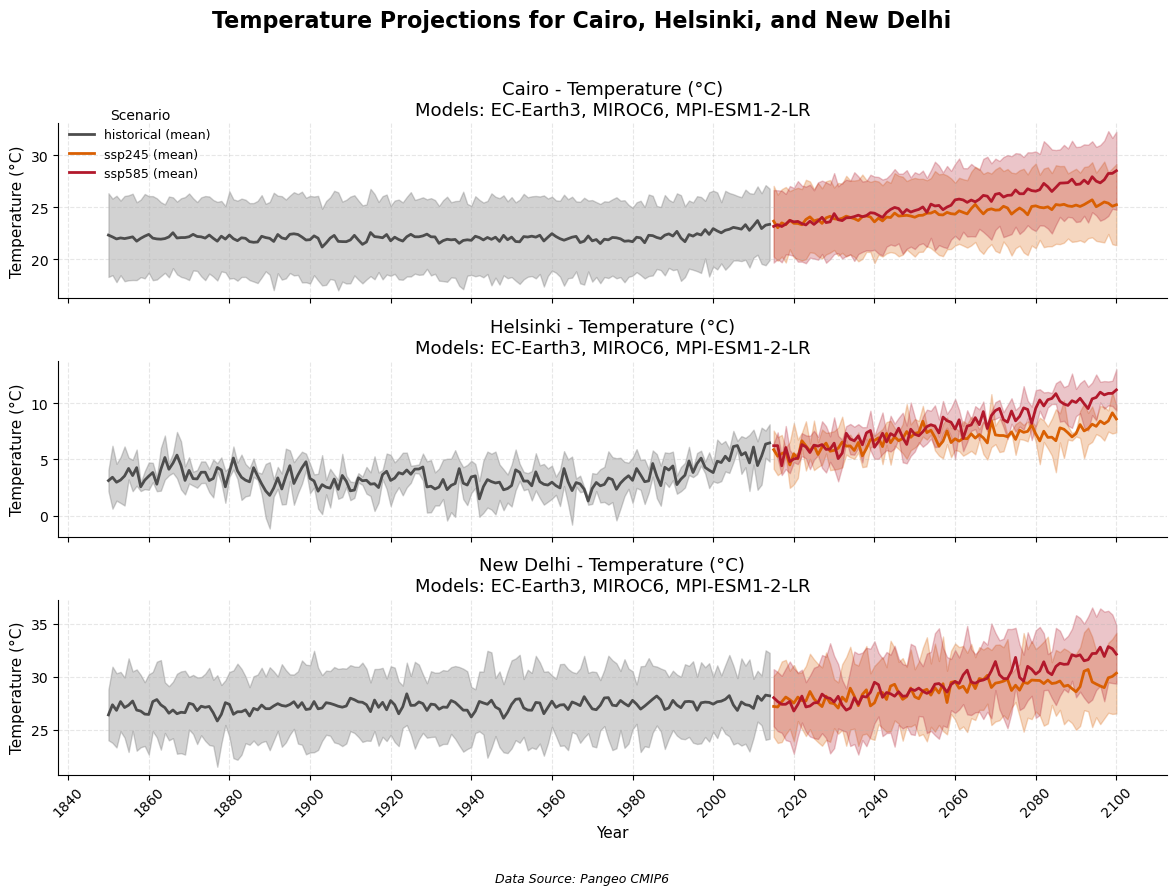

Temperature figure saved to: Temperature_Timeseries.png


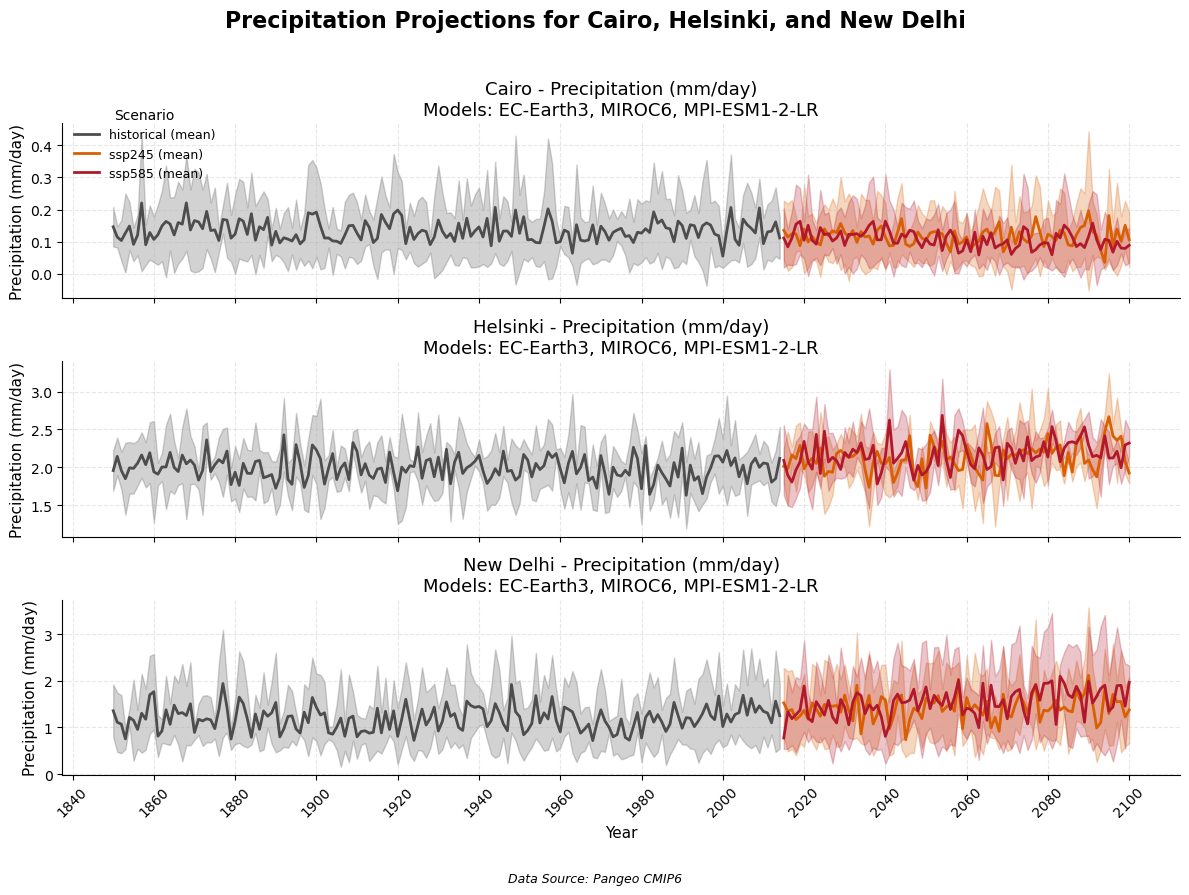

Precipitation figure saved to: Precipitation_Timeseries.png


In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as mticker
import os

# Input file paths for CMIP6 climate data (temperature and precipitation)
# for selected cities.
files = {
    "Cairo": "CMIP6_extracts/Cairo_data.csv",
    "Helsinki": "CMIP6_extracts/Helsinki_data.csv",
    "New Delhi": "CMIP6_extracts/New_Delhi_data.csv",
}

# Define consistent color scheme for each emission scenario
scenario_colors = {
    "historical": "#4D4D4D",  # dark gray for historical data
    "ssp245": "#d95f02",      # orange for SSP2-4.5
    "ssp585": "#b2182b"       # red for SSP5-8.5
}
scenario_order = ["historical", "ssp245", "ssp585"]

# Function to process and summarize annual temperature and precipitation data
# for a single city. Aggregates across models to calculate mean and spread.
def process_city_data(path):
    df = pd.read_csv(path)
    df['time'] = pd.to_datetime(df['time'])
    df['year'] = df['time'].dt.year

    # Compute model-wise annual means
    annual_means = df.groupby(['year', 'scenario', 'model'])[
        ['temperature_C', 'precipitation_mm_per_day']
    ].mean().reset_index()

    # Calculate scenario-wise ensemble mean and standard deviation
    temp_stats = annual_means.groupby(['year', 'scenario'])['temperature_C'].agg(['mean', 'std']).reset_index()
    precip_stats = annual_means.groupby(['year', 'scenario'])['precipitation_mm_per_day'].agg(['mean', 'std']).reset_index()

    # Retrieve list of models used for labeling
    models_used = ", ".join(sorted(annual_means['model'].unique()))

    return temp_stats, precip_stats, models_used

# Function to generate a 3-row temperature time series plot (one per city)
# Shows ensemble mean and shaded spread for each scenario.
def plot_temperature(city_stats, output_path="Temperature_Timeseries.png"):
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 9), sharex=True)

    for i, (city, stats) in enumerate(city_stats.items()):
        ax = axes[i]
        temp_stats = stats["temp"]
        models_used = stats["models"]

        # Plot mean and spread per scenario
        for scenario in scenario_order:
            data = temp_stats[temp_stats['scenario'] == scenario]
            if not data.empty:
                years = data['year']
                mean = data['mean']
                std = data['std']
                color = scenario_colors.get(scenario, "#333333")
                ax.plot(years, mean, label=f"{scenario} (mean)", color=color, linewidth=2)
                ax.fill_between(years, mean - std, mean + std, alpha=0.25, color=color)

        # Formatting
        ax.set_title(f"{city} - Temperature (°C)\nModels: {models_used}", fontsize=13)
        ax.set_ylabel("Temperature (°C)", fontsize=11)
        ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{int(x)}"))  # Show numeric years
        ax.xaxis.set_major_locator(mticker.MultipleLocator(20))
        ax.tick_params(axis='x', rotation=45)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.grid(True, linestyle="--", alpha=0.3)

        # Add legend to the top plot only
        if i == 0:
            ax.legend(
                title="Scenario",
                loc="upper left",
                bbox_to_anchor=(0, 1.15),
                frameon=False,
                fontsize=9,
                title_fontsize=10
            )

        # Add x-axis label only to the bottom plot
        if i == len(axes) - 1:
            ax.set_xlabel("Year", fontsize=11)

    # Global title and footer
    fig.suptitle("Temperature Projections for Cairo, Helsinki, and New Delhi", fontsize=16, fontweight='bold')
    fig.text(0.5, 0.01, 'Data Source: Pangeo CMIP6', ha='center', fontsize=9, style='italic')

    # Layout adjustments
    plt.tight_layout(rect=[0, 0.04, 1, 0.96])
    plt.savefig(output_path, dpi=300, bbox_inches="tight")
    plt.show()
    print(f"Temperature figure saved to: {output_path}")

# Function to generate a 3-row precipitation time series plot (one per city)
# Displays ensemble means with uncertainty shading per scenario.
def plot_precipitation(city_stats, output_path="Precipitation_Timeseries.png"):
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 9), sharex=True)

    for i, (city, stats) in enumerate(city_stats.items()):
        ax = axes[i]
        precip_stats = stats["precip"]
        models_used = stats["models"]

        # Plot mean and spread per scenario
        for scenario in scenario_order:
            data = precip_stats[precip_stats['scenario'] == scenario]
            if not data.empty:
                years = data['year']
                mean = data['mean']
                std = data['std']
                color = scenario_colors.get(scenario, "#333333")
                ax.plot(years, mean, label=f"{scenario} (mean)", color=color, linewidth=2)
                ax.fill_between(years, mean - std, mean + std, alpha=0.25, color=color)

        # Formatting
        ax.set_title(f"{city} - Precipitation (mm/day)\nModels: {models_used}", fontsize=13)
        ax.set_ylabel("Precipitation (mm/day)", fontsize=11)
        ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{int(x)}"))
        ax.xaxis.set_major_locator(mticker.MultipleLocator(20))
        ax.tick_params(axis='x', rotation=45)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.grid(True, linestyle="--", alpha=0.3)

        # Add legend to the top plot only
        if i == 0:
            ax.legend(
                title="Scenario",
                loc="upper left",
                bbox_to_anchor=(0, 1.15),
                frameon=False,
                fontsize=9,
                title_fontsize=10
            )

        # Add x-axis label only to the bottom plot
        if i == len(axes) - 1:
            ax.set_xlabel("Year", fontsize=11)

    # Global title and footer
    fig.suptitle("Precipitation Projections for Cairo, Helsinki, and New Delhi", fontsize=16, fontweight='bold')
    fig.text(0.5, 0.01, 'Data Source: Pangeo CMIP6', ha='center', fontsize=9, style='italic')

    # Layout adjustments
    plt.tight_layout(rect=[0, 0.04, 1, 0.96])
    plt.savefig(output_path, dpi=300, bbox_inches="tight")
    plt.show()
    print(f"Precipitation figure saved to: {output_path}")

# Main script execution: process each city's dataset and generate final figures
def main():
    city_stats = {}

    for city, path in files.items():
        if os.path.exists(path):
            temp_stats, precip_stats, models_used = process_city_data(path)
            city_stats[city] = {
                "temp": temp_stats,
                "precip": precip_stats,
                "models": models_used
            }
        else:
            print(f"File not found for {city}: {path}")

    # Generate plots if data is available
    if city_stats:
        plot_temperature(city_stats)
        plot_precipitation(city_stats)
    else:
        print("No valid data available for plotting.")

# Entry point
if __name__ == "__main__":
    main()
